<a href="https://colab.research.google.com/github/lyeslehara1996/PFE/blob/main/VAE_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.optimizers import Adam,Adamax,Adagrad,SGD
import keras.metrics as metrics
from keras import backend as K
from keras.layers import Bidirectional, Dense, Embedding, Input, Lambda, LSTM,GRU, RepeatVector, TimeDistributed, Layer, Activation, Dropout
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from tensorflow import  keras
import pandas as pd 
import re 
import nltk


import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import zeros
from keras.layers import Dropout

from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer
import string as st
SAVEd = False


from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
nltk.download('stopwords')
nltk.download('punkt')
""" Dataset"""

from keras.wrappers.scikit_learn import KerasClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from tensorflow.python.framework.ops import disable_eager_execution

# import tensorflow as tf
from tensorflow.python.eager.context import eager_mode, graph_mode
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:

df=pd.read_excel("/content/drive/MyDrive/dossier_de_travail/SemEval2017A.xlsx")

df.drop("Unnamed: 3", axis=1, inplace=True)
df.drop("Unnamed: 4", axis=1, inplace=True)
df.drop("Unnamed: 5", axis=1, inplace=True)
df.drop("Unnamed: 6", axis=1, inplace=True)

df.head()


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20633 entries, 0 to 20632
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        20633 non-null  object
 1   Polarity  20632 non-null  object
 2   Comments  20632 non-null  object
dtypes: object(3)
memory usage: 483.7+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20632 entries, 0 to 20632
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        20632 non-null  object
 1   Polarity  20632 non-null  object
 2   Comments  20632 non-null  object
dtypes: object(3)
memory usage: 644.8+ KB


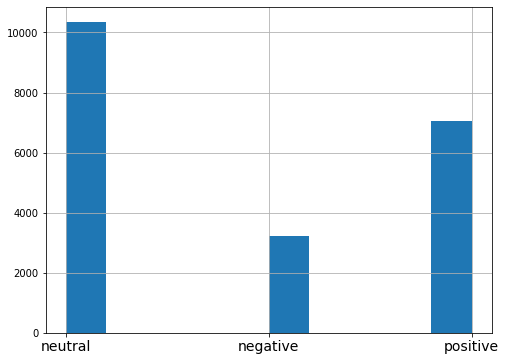

,ID,Polarity,Comments
0,619950566786113024,neutral,"picturehouse's, pink floyd's, 'roger waters: t..."
1,619969366986235008,neutral,order go set a watchman in store or through ou...
2,619971047195044992,negative,if these runway renovations at the airport pre...
3,619974445185302016,neutral,if you could ask an onstage interview question...
4,619987808317406976,positive,a portion of book sales from our harper lee/go...


In [6]:

#supprimer les lignes qui contient des valeur null 
df.Polarity.unique()
df.dropna(subset=['Polarity'], inplace=True)
df.Polarity.unique()
df.info()


plt.figure(figsize=(8,6))
df.Polarity.hist(xlabelsize=14)
plt.show()

#### transformet les mots en miniscule ######
df.Comments=df.Comments.str.lower()
df.head()

In [7]:

###################STOP WORDS################
#STOP WORDS
#Tokenization of text

tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['Comments']=df['Comments'].apply(remove_stopwords)

In [8]:

############supprission des caractere spiciaux Dans Commantaire #########
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'{link}', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'&[a-z]+;', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r"[^a-z]", ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: re.sub(r'@mention', ' ', str(x)))
df['Comments'] = df['Comments'].apply(lambda x: " ".join(x.lower() for x in str(x).split()  if len(x)>3 ))

In [9]:
#######deviser en review and labels ######


reviews =  df[['Comments']]
labels =  df[['Polarity']]

corpus= []
for text in reviews['Comments']:
    words= [word.lower() for word in word_tokenize(text)]
    corpus.append(words)

num_words=len(corpus)
print(num_words)

20632


In [10]:
####reviews sans ponctuation #######

revue_sans_ponctuation=[]
for sentence in reviews['Comments']:

    revue_sans_ponctuation.append(' '.join(Word.strip(st.punctuation) for Word in sentence.split()))

reviews_cleaned = np.asarray(revue_sans_ponctuation)
reviews_cleaned



review_array = np.asarray(revue_sans_ponctuation)
label_array = np.asarray(labels['Polarity'])

reviews_labels = np.stack((review_array, label_array), axis = 1)

reviews_labels

array([['picturehouse pink floyd roger waters walll opening sept making waves watch trailer rolling stone look',
        'neutral'],
       ['order watchman store website tuesday half price gsaw gsawatchmanbook',
        'neutral'],
       ['runway renovations airport prevent seeing taylor swift monday blood meaning',
        'negative'],
       ...,
       ['hours arrived saudi arabia tuesday turkish president recep tayyip erdogan accused syria president mercilessly',
        'neutral'],
       ['vanityfair alex kardashian worth love kardashian conure',
        'negative'],
       ['guess even pandora knows justin bieber grown condom played',
        'neutral']], dtype=object)

In [11]:
########Encoder les polarity  ##############
encoder = LabelEncoder()
encoder.fit(label_array)
encoded_labels = encoder.transform(label_array)
encoded_labels = to_categorical(encoded_labels)
encoded_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
##### Train and Test
review_train, review_test, label_train, label_test = train_test_split(reviews_cleaned, encoded_labels, test_size=0.20, random_state=42)
print(review_train.shape, label_train.shape)
print(review_test.shape, label_test.shape)

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

vocab_size = len(tokenizer.word_index) + 1

(16505,) (16505, 3)
(4127,) (4127, 3)


In [13]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/dossier_de_travail/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
print(embedding_matrix[1].shape)

(100,)


In [14]:
X_train=review_train  
X_test=review_test
y_train=label_train   
y_test=label_test
MAX_LENGTH = 100
NUM_WORDS = vocab_size
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LENGTH)

train_index = np.random.choice(np.arange(X_train.shape[0]), 350, replace=False)     
test_index = np.random.choice(np.arange(X_test.shape[0]), 250, replace=False)      

X_train = X_train[train_index]
y_train = y_train[train_index]

X_test = X_test[test_index]
y_test = y_test[test_index]

temp = np.zeros((X_train.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_train.shape[0]), axis=0).reshape(X_train.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_train.shape[0], axis=0), X_train] = 1

Conversion_X_train = temp

temp = np.zeros((X_test.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_test.shape[0]), axis=0).reshape(X_test.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_test.shape[0], axis=0), X_test] = 1

Conversion_X_test = temp
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)
print(Conversion_X_train.shape)
print(Conversion_X_test.shape)


X_train (350, 100)
y_train (350, 3)
X_test (250, 100)
y_test (250, 3)
(350, 100, 22814)
(250, 100, 22814)


In [15]:

from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:

class AttentionCouche(tf.keras.layers.Layer): 
    def __init__(self, **kwargs):   
        self.dim_mots = 200
        self.unite_par_seq =100 

        super(AttentionCouche, self).__init__( **kwargs)
        
    def build(self, input_shape):

        dim_mots = input_shape[-1] 
        unite_par_seq = input_shape[-2]
        num_units = 1
        
        self.w = self.add_weight(name='attention_weigth',shape=(input_shape[-1],1), initializer='normal')            
        self.b = self.add_weight(name='attention_bias',shape=(input_shape[-2],1), initializer='zero')
       
        
        super(AttentionCouche, self).build(input_shape)
        
    def call(self, x):
       e=K.tanh(K.dot(x,self.w)+self.b) 
       e = Flatten()(e) 
       a = Activation('softmax')(e)
       temp = RepeatVector(1000)(a) 
       temp = Permute([2,1])(temp) 
       output = Multiply()([x,temp]) 
       output = Lambda(lambda values: K.sum(values, axis=1))(output)
       return output
    def output_shep(self,input_shape):
      return (input_shape[0],input_shape[-1])
    def get_config(self):
      return super(AttentionCouche,self).get_config()

# **Tester**

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'modelAdam.h5'
LR=0.0001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)

def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.5,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()

def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)
    
encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()

def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h =  LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.4,recurrent_dropout=0.2)(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_pred_loss', mode='min', verbose=1, patience=30)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer='adam', loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=150, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 300 samples, validate on 250 samples
Epoch 1/150
300/300 [==============================] - ETA: 0s - loss: 0.6985 - decoded_mean_loss: 0.0503 - pred_loss: 0.6443 - decoded_mean_acc: 0.5050 - pred_acc: 0.6733

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: pred_acc improved from -inf to 0.67333, saving model to /content/drive/MyDrive/dossier_de_travail/modelAdam.h5
300/300 [==============================] - 65s 215ms/sample - loss: 0.6985 - decoded_mean_loss: 0.0503 - pred_loss: 0.6443 - decoded_mean_acc: 0.5050 - pred_acc: 0.6733 - val_loss: 0.6260 - val_decoded_mean_loss: 0.0564 - val_pred_loss: 0.5792 - val_decoded_mean_acc: 0.9317 - val_pred_acc: 0.7040
Epoch 2/150
300/300 [==============================] - ETA: 0s - loss: 0.6310 - decoded_mean_loss: 0.0509 - pred_loss: 0.5794 - decoded_mean_acc: 0.9298 - pred_acc: 0.6956
Epoch 00002: pred_acc improved from 0.67333 to 0.69556, saving model to /content/drive/MyDrive/dossier_de_travail/modelAdam.h5
300/300 [==============================] - 62s 206ms/sample - loss: 0.6310 - decoded_mean_loss: 0.0509 - pred_loss: 0.5794 - decoded_mean_acc: 0.9298 - pred_acc: 0.6956 - val_loss: 0.6087 - val_decoded_mean_loss: 0.0433 - val_pred_loss: 0.5782 - val_decoded_mean_acc: 0.9317 - v

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[1.0451834006309508, 0.012603982, 1.0309818, 0.93172, 0.72666675]

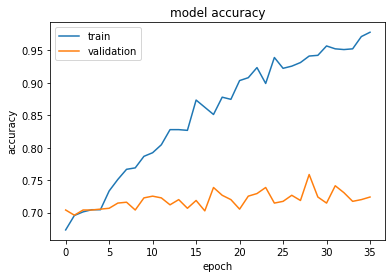

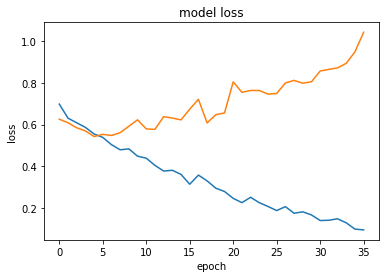

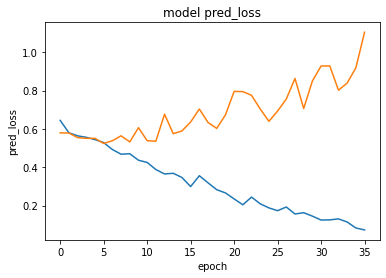

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[1.0450446138381957, 0.012604279, 1.0308837, 0.93172, 0.72400004]

# Model1:avec une couche et optimizer ADAM learning rate 0.0001

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'best_modelAdam_LR.h5'
LR=0.0001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.4,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()

def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()

def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h =LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.4,recurrent_dropout=0.2)(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_pred_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     2281400     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 1000)    2404000     embedding_1[0][0]                
__________________________________________________________________________________________________
attention_couche_1 (AttentionCo (None, 1000)         1100        bidirectional_1[0][0]            
____________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 300 samples, validate on 250 samples
Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.7399 - decoded_mean_loss: 0.0484 - pred_loss: 0.6915 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/dossier_de_travail/best_modelAdam_LR.h5
300/300 [==============================] - 64s 212ms/sample - loss: 0.7399 - decoded_mean_loss: 0.0484 - pred_loss: 0.6915 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667 - val_loss: 0.7347 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6865 - val_decoded_mean_acc: 0.0039 - val_pred_acc: 0.6667
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.7322 - decoded_mean_loss: 0.0484 - pred_loss: 0.6838 - decoded_mean_acc: 0.0061 - pred_acc: 0.6667     
Epoch 00002: val_pred_acc did not improve from 0.66667
300/300 [==============================] - 57s 191ms/sample - loss: 0.7322 - decoded_mean_loss: 0.0484 - pred_loss: 0.6838 - decoded_mean_acc: 0.0061 - pred_acc: 0.6667 - val_loss: 0.7270 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6794 - val_decoded_mean_acc: 0.1840 - val_pred_acc: 0.6667
Epoch 3/100
300/300 [==========

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.5575524001121521, 0.012598202, 0.5428949, 0.93172, 0.72]

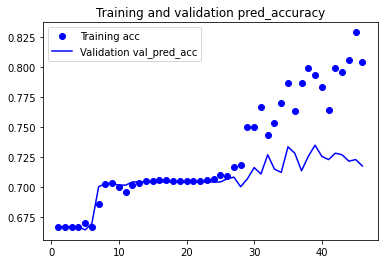

<Figure size 432x288 with 0 Axes>

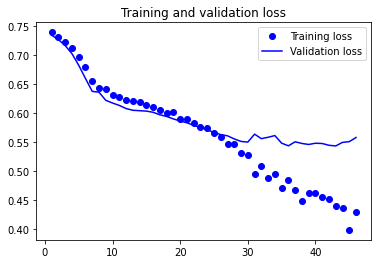

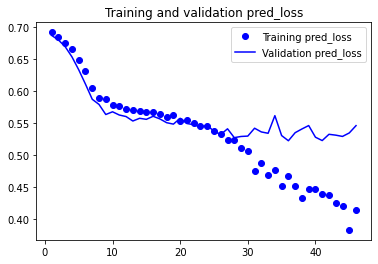

In [ ]:
# plt.plot(history.history['pred_acc'])
# plt.plot(history.history['val_pred_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # Plot of loss in each epoch
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.show()

# plt.plot(history.history['pred_loss'])
# plt.plot(history.history['val_pred_loss'])
# plt.title('model pred_loss')
# plt.ylabel('pred_loss')
# plt.xlabel('epoch')
# plt.show()

pred_acc = history.history['pred_acc']
val_pred_acc = history.history['val_pred_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

pred_loss = history.history['pred_loss']
val_pred_loss = history.history['val_pred_loss']

epochs = range(1, len(pred_acc) + 1)

plt.plot(epochs, pred_acc, 'bo', label='Training acc')
plt.plot(epochs, val_pred_acc, 'b', label='Validation val_pred_acc')
plt.title('Training and validation pred_accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, pred_loss, 'bo', label='Training pred_loss')
plt.plot(epochs, val_pred_loss, 'b', label='Validation pred_loss')
plt.title('Training and validation pred_loss')
plt.legend()
plt.show()

**without early stopped**

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'best_modelAdam_LR_sans_Early.h5'
LR=0.0001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.5,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()

def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()

def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h =LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.4,recurrent_dropout=0.2)(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


# early_stopping = EarlyStopping(monitor='val_pred_loss', mode='min', verbose=1, patience=10)

# save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
#                      monitor='val_pred_acc', 
#                      mode='max', 
#                      verbose=1, 
#                      save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     2281400     input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 100, 1000)    2404000     embedding_3[0][0]                
__________________________________________________________________________________________________
attention_couche_3 (AttentionCo (None, 1000)         1100        bidirectional_3[0][0]            
___________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}))


Train on 300 samples, validate on 250 samples
Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.7384 - decoded_mean_loss: 0.0484 - pred_loss: 0.6898 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


300/300 [==============================] - 63s 210ms/sample - loss: 0.7384 - decoded_mean_loss: 0.0484 - pred_loss: 0.6898 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667 - val_loss: 0.7298 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6809 - val_decoded_mean_acc: 0.0036 - val_pred_acc: 0.6667
Epoch 2/100
300/300 [==============================] - 60s 201ms/sample - loss: 0.7259 - decoded_mean_loss: 0.0484 - pred_loss: 0.6771 - decoded_mean_acc: 0.0173 - pred_acc: 0.6667 - val_loss: 0.7142 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6650 - val_decoded_mean_acc: 0.1868 - val_pred_acc: 0.6667
Epoch 3/100
300/300 [==============================] - 60s 201ms/sample - loss: 0.7099 - decoded_mean_loss: 0.0485 - pred_loss: 0.6610 - decoded_mean_acc: 0.1533 - pred_acc: 0.6667 - val_loss: 0.6931 - val_decoded_mean_loss: 0.0486 - val_pred_loss: 0.6476 - val_decoded_mean_acc: 0.8766 - val_pred_acc: 0.6667
Epoch 4/100
300/300 [==============================] - 60s 201ms/sample - loss

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.6989929962158203, 0.013589691, 0.6815251, 0.93172, 0.7306667]

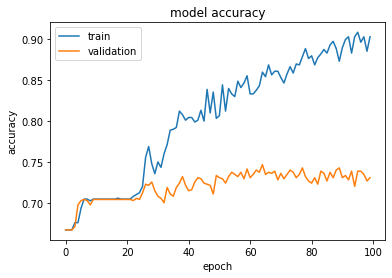

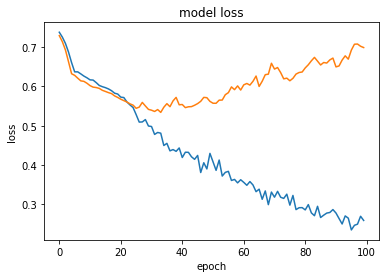

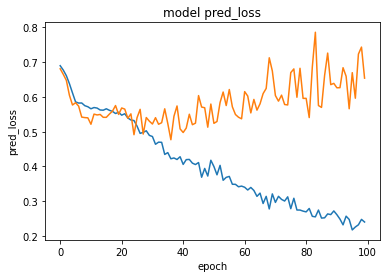

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()


**with LR=0.001**

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'modelAdam_LR2.h5'
LR=0.001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.5,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])

    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()

def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()

def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h =LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.4,recurrent_dropout=0.2)(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_pred_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 100)     2281400     input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 1000)    2404000     embedding_5[0][0]                
__________________________________________________________________________________________________
attention_couche_5 (AttentionCo (None, 1000)         1100        bidirectional_5[0][0]            
___________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 300 samples, validate on 250 samples
Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.6956 - decoded_mean_loss: 0.0498 - pred_loss: 0.6414 - decoded_mean_acc: 0.4920 - pred_acc: 0.6744

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_pred_acc improved from -inf to 0.70400, saving model to /content/drive/MyDrive/dossier_de_travail/modelAdam_LR2.h5
300/300 [==============================] - 69s 231ms/sample - loss: 0.6956 - decoded_mean_loss: 0.0498 - pred_loss: 0.6414 - decoded_mean_acc: 0.4920 - pred_acc: 0.6744 - val_loss: 0.7305 - val_decoded_mean_loss: 0.0711 - val_pred_loss: 0.6609 - val_decoded_mean_acc: 0.9317 - val_pred_acc: 0.7040
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.6699 - decoded_mean_loss: 0.0550 - pred_loss: 0.6134 - decoded_mean_acc: 0.9298 - pred_acc: 0.6900
Epoch 00002: val_pred_acc did not improve from 0.70400
300/300 [==============================] - 63s 211ms/sample - loss: 0.6699 - decoded_mean_loss: 0.0550 - pred_loss: 0.6134 - decoded_mean_acc: 0.9298 - pred_acc: 0.6900 - val_loss: 0.6295 - val_decoded_mean_loss: 0.0433 - val_pred_loss: 0.5876 - val_decoded_mean_acc: 0.9317 - val_pred_acc: 0.6773
Epoch 3/100
300/300 [=======================

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.6954980182647705, 0.01292989, 0.6832105, 0.93172, 0.7173334]

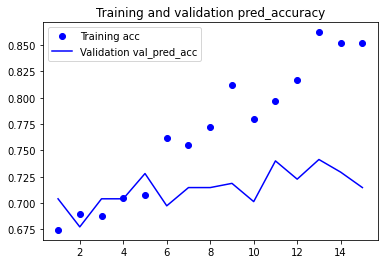

<Figure size 432x288 with 0 Axes>

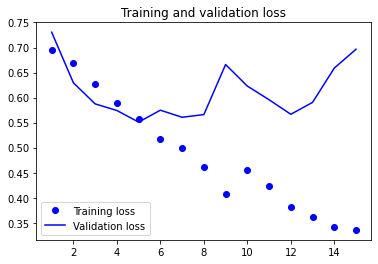

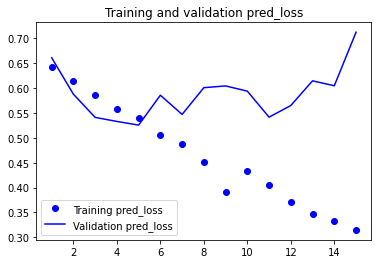

In [ ]:

pred_acc = history.history['pred_acc']
val_pred_acc = history.history['val_pred_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

pred_loss = history.history['pred_loss']
val_pred_loss = history.history['val_pred_loss']

epochs = range(1, len(pred_acc) + 1)

plt.plot(epochs, pred_acc, 'bo', label='Training acc')
plt.plot(epochs, val_pred_acc, 'b', label='Validation val_pred_acc')
plt.title('Training and validation pred_accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, pred_loss, 'bo', label='Training pred_loss')
plt.plot(epochs, val_pred_loss, 'b', label='Validation pred_loss')
plt.title('Training and validation pred_loss')
plt.legend()
plt.show()

# Model2
 aveec ADAM plus couche learning rate 0.0001 plusieur couche**

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'modelAdam_LR+couche.h5'
LR=0.0001
batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500
encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500,return_sequences=True,dropout=0.4,recurrent_dropout=0.2))(x)
    h=Dropout(0.4)(h)
    h = Bidirectional(LSTM(250,return_sequences=True,dropout=0.4,recurrent_dropout=0.2),merge_mode='concat')(h)
    h = AttentionCouche()(h) 
    h=Dropout(0.4)(h)
    h = Dense(300, activation='relu', name='dense_1')(h)
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])
    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    return (fct_loss, z) 
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()
def Codage_opinion(encoded):
    h = Dense(300, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)

encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()
def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional(  LSTM(250, return_sequences=True, name='dec_lstm_1',dropout=0.4,recurrent_dropout=0.2))(repeated_context)
    h=Dropout(0.4)(h)
    h = Bidirectional(  LSTM(100, return_sequences=True, name='dec_lstm_1',dropout=0.4,recurrent_dropout=0.2))(h)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_pred_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 

autoencoder.compile(optimizer=Adam(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=60, epochs=150, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 250 samples, validate on 200 samples
Epoch 1/150
250/250 [==============================] - ETA: 0s - loss: 0.7394 - decoded_mean_loss: 0.0485 - pred_loss: 0.6901 - decoded_mean_acc: 3.6000e-04 - pred_acc: 0.6667

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/dossier_de_travail/modelAdam_LR+couche.h5
250/250 [==============================] - 64s 258ms/sample - loss: 0.7394 - decoded_mean_loss: 0.0485 - pred_loss: 0.6901 - decoded_mean_acc: 3.6000e-04 - pred_acc: 0.6667 - val_loss: 0.7312 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6834 - val_decoded_mean_acc: 0.0106 - val_pred_acc: 0.6667
Epoch 2/150
250/250 [==============================] - ETA: 0s - loss: 0.7256 - decoded_mean_loss: 0.0485 - pred_loss: 0.6766 - decoded_mean_acc: 0.0094 - pred_acc: 0.6667
Epoch 00002: val_pred_acc did not improve from 0.66667
250/250 [==============================] - 56s 223ms/sample - loss: 0.7256 - decoded_mean_loss: 0.0485 - pred_loss: 0.6766 - decoded_mean_acc: 0.0094 - pred_acc: 0.6667 - val_loss: 0.7147 - val_decoded_mean_loss: 0.0485 - val_pred_loss: 0.6651 - val_decoded_mean_acc: 0.3432 - val_pred_acc: 0.6667
Epoch 3/150
250/250 [=============

In [ ]:
autoencoder.evaluate(x=X_test, y={'decoded_mean': Conversion_X_test, 'pred': y_test})

[0.6217363333702087, 0.02118944, 0.5887681, 0.93235, 0.69500005]

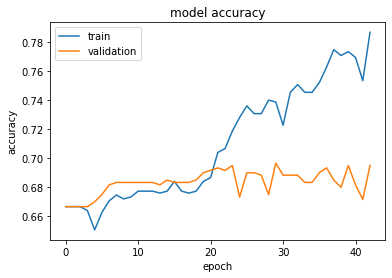

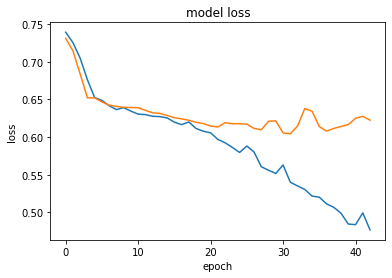

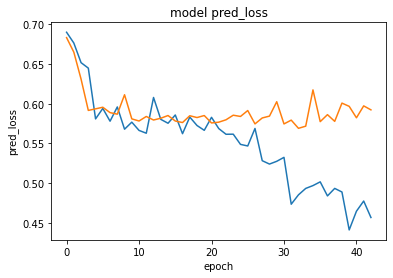

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

# **Model3** using:
optimazer adamax
une couche encoder+decoder


In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'adamax_model.h5'
LR=0.0001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)


def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.2,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])


    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
    
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()


def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)


encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()


def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = LSTM(500, return_sequences=True, name='dec_lstm_1',dropout=0.2,recurrent_dropout=0.2)(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='val_pred_loss', mode='min', verbose=1, patience=20)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='val_pred_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True) 
autoencoder.compile(optimizer='adamax', loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 100)     2281400     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 100, 1000)    2404000     embedding_2[0][0]                
__________________________________________________________________________________________________
attention_couche_2 (AttentionCo (None, 1000)         1100        bidirectional_7[0][0]            
____________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 300 samples, validate on 200 samples
Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.7077 - decoded_mean_loss: 0.0486 - pred_loss: 0.6590 - decoded_mean_acc: 0.6123 - pred_acc: 0.6711 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_pred_acc improved from -inf to 0.66333, saving model to /content/drive/MyDrive/dossier_de_travail/adamax_model.h5
300/300 [==============================] - 60s 200ms/sample - loss: 0.7077 - decoded_mean_loss: 0.0486 - pred_loss: 0.6590 - decoded_mean_acc: 0.6123 - pred_acc: 0.6711 - val_loss: 0.6703 - val_decoded_mean_loss: 0.0528 - val_pred_loss: 0.6175 - val_decoded_mean_acc: 0.9317 - val_pred_acc: 0.6633
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.6419 - decoded_mean_loss: 0.0538 - pred_loss: 0.5881 - decoded_mean_acc: 0.9324 - pred_acc: 0.6889 
Epoch 00002: val_pred_acc improved from 0.66333 to 0.67000, saving model to /content/drive/MyDrive/dossier_de_travail/adamax_model.h5
300/300 [==============================] - 57s 189ms/sample - loss: 0.6419 - decoded_mean_loss: 0.0538 - pred_loss: 0.5881 - decoded_mean_acc: 0.9324 - pred_acc: 0.6889 - val_loss: 0.6771 - val_decoded_mean_loss: 0.0497 - val_pred_loss: 0.6274 - val_decoded_mean_

In [ ]:
autoencoder.evaluate(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test})

[0.7569005167484284, 0.012672422, 0.70871085, 0.9317, 0.685]

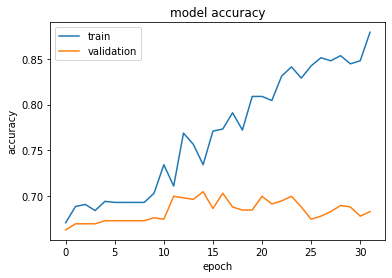

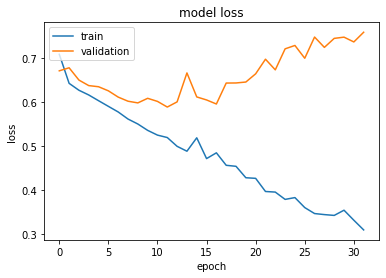

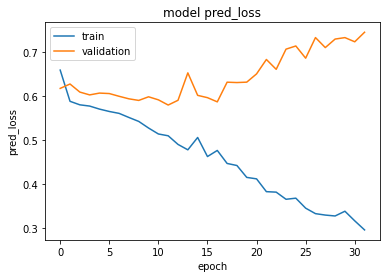

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Model4**
une couche avec 100 epouch avec adamax et learning rate = 0.0001


In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'Adamaxmodel0.001.h5'
LR=0.0001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)


def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.4,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])


    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
    
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()


def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)


encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()


def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = LSTM(500, return_sequences=True, name='dec_lstm_1')(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=7)
save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='pred_acc', 

                     mode='max', 
                     verbose=1, 
                     save_best_only=True)  
autoencoder.compile(optimizer=Adamax(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     2281400     input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 100, 1000)    2404000     embedding_3[0][0]                
__________________________________________________________________________________________________
attention_couche_3 (AttentionCo (None, 1000)         1100        bidirectional_8[0][0]            
____________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 400 samples, validate on 250 samples
Epoch 1/100
400/400 [==============================] - ETA: 0s - loss: 0.7395 - decoded_mean_loss: 0.0484 - pred_loss: 0.6911 - decoded_mean_acc: 0.0165 - pred_acc: 0.6667 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/dossier_de_travail/Adamaxmodel0.0001.h5
400/400 [==============================] - 79s 198ms/sample - loss: 0.7395 - decoded_mean_loss: 0.0484 - pred_loss: 0.6911 - decoded_mean_acc: 0.0165 - pred_acc: 0.6667 - val_loss: 0.7340 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6857 - val_decoded_mean_acc: 0.2594 - val_pred_acc: 0.6667
Epoch 2/100
400/400 [==============================] - ETA: 0s - loss: 0.7310 - decoded_mean_loss: 0.0484 - pred_loss: 0.6826 - decoded_mean_acc: 0.6368 - pred_acc: 0.6667 
Epoch 00002: pred_acc did not improve from 0.66667
400/400 [==============================] - 70s 174ms/sample - loss: 0.7310 - decoded_mean_loss: 0.0484 - pred_loss: 0.6826 - decoded_mean_acc: 0.6368 - pred_acc: 0.6667 - val_loss: 0.7251 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6767 - val_decoded_mean_acc: 0.9271 - val_pred_acc: 0.6667
Epoch 3/100
400/400 [==========================

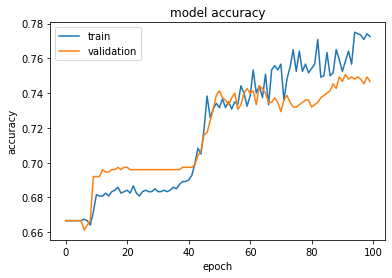

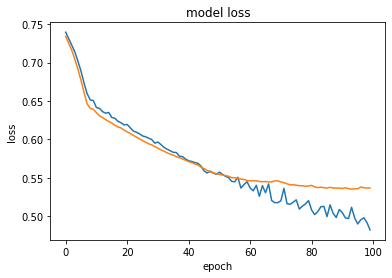

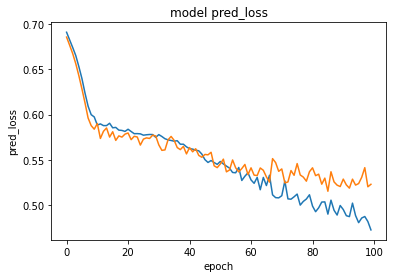

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
autoencoder.evaluate(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test})

[0.5366729431152344, 0.009308544, 0.5265156, 0.93156, 0.7453333]

**test_2**

In [ ]:
#test2

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=100, epochs=150, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()



pred_acc = history.history['pred_acc']
val_pred_acc = history.history['val_pred_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

pred_loss = history.history['pred_loss']
val_pred_loss = history.history['val_pred_loss']

epochs = range(1, len(pred_acc) + 1)

plt.plot(epochs, pred_acc, 'bo', label='Training acc')
plt.plot(epochs, val_pred_acc, 'b', label='Validation val_pred_acc')
plt.title('Training and validation pred_accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, pred_loss, 'bo', label='Training pred_loss')
plt.plot(epochs, val_pred_loss, 'b', label='Validation pred_loss')
plt.title('Training and validation pred_loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.evaluate(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test})

une couche avec lr 0.001

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'Adamaxmodel0.001.h5'
LR=0.001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)


def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.4,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])


    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
    
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()


def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)


encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()


def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = LSTM(500, return_sequences=True, name='dec_lstm_1')(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='pred_acc', 

                     mode='max', 
                     verbose=1, 
                     save_best_only=True)  
autoencoder.compile(optimizer=Adamax(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 500 samples, validate on 250 samples
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.6978 - decoded_mean_loss: 0.0513 - pred_loss: 0.6493 - decoded_mean_acc: 0.7826 - pred_acc: 0.6613

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: pred_acc improved from -inf to 0.66133, saving model to /content/drive/MyDrive/dossier_de_travail/Adamaxmodel0.001.h5
500/500 [==============================] - 93s 186ms/sample - loss: 0.6978 - decoded_mean_loss: 0.0513 - pred_loss: 0.6493 - decoded_mean_acc: 0.7826 - pred_acc: 0.6613 - val_loss: 0.6493 - val_decoded_mean_loss: 0.0436 - val_pred_loss: 0.5899 - val_decoded_mean_acc: 0.9317 - val_pred_acc: 0.6773
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.6489 - decoded_mean_loss: 0.0364 - pred_loss: 0.6038 - decoded_mean_acc: 0.9306 - pred_acc: 0.6727
Epoch 00002: pred_acc improved from 0.66133 to 0.67267, saving model to /content/drive/MyDrive/dossier_de_travail/Adamaxmodel0.001.h5
500/500 [==============================] - 89s 178ms/sample - loss: 0.6489 - decoded_mean_loss: 0.0364 - pred_loss: 0.6038 - decoded_mean_acc: 0.9306 - pred_acc: 0.6727 - val_loss: 0.6297 - val_decoded_mean_loss: 0.0269 - val_pred_loss: 0.6019 - val_decoded_mean_a

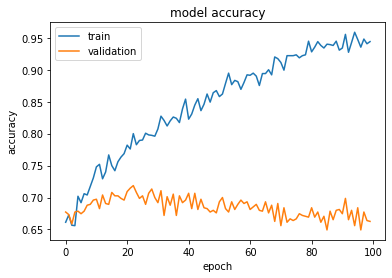

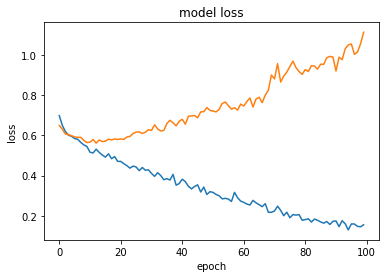

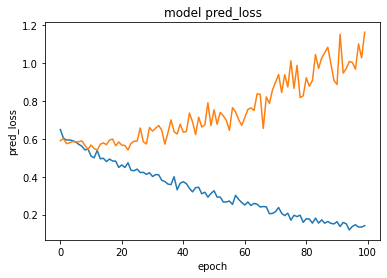

In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
autoencoder.evaluate(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test})

[1.111734236240387, 0.00787754, 1.097749, 0.93184, 0.6653334]

# **Model5** adamax pleusieur couche avec 200 epoch et LR=0.001 

In [ ]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'model5.h5'
LR=0.0001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)


def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.4,recurrent_dropout=0.2))(x)
    h=Dropout(0.4)(h)
    h = Bidirectional(LSTM(250, return_sequences=True,dropout=0.4,recurrent_dropout=0.2))(h)
    h=Dropout(0.4)(h)
    h = Bidirectional(LSTM(50, return_sequences=True,dropout=0.4,recurrent_dropout=0.2),merge_mode='concat')(h)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])


    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
    
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()


def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)


encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()


def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.4,recurrent_dropout=0.2, name='dec_lstm_1'))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='pred_acc', 

                     mode='max', 
                     verbose=1, 
                     save_best_only=True)  
autoencoder.compile(optimizer=Adamax(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=200, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

# **Model6** 
using: plusieur couche and epochs,adamax+learning_rate=0.0001


In [18]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'model6.h5'
LR=0.0001
batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500
encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)
def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.4,recurrent_dropout=0.2))(x)
    h=Dropout(0.4)(h)
    h = Bidirectional(LSTM(250, return_sequences=True,dropout=0.4,recurrent_dropout=0.2))(h)
    h=Dropout(0.4)(h)
    h = Bidirectional(LSTM(50, return_sequences=True,dropout=0.4,recurrent_dropout=0.2),merge_mode='concat')(h)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])
    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()
def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)
    
encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()

def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = Bidirectional(LSTM(250, return_sequences=True,dropout=0.4,recurrent_dropout=0.2, name='dec_lstm_1'))(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='pred_acc', 

                     mode='max', 
                     verbose=1, 
                     save_best_only=True)  
autoencoder.compile(optimizer=Adamax(learning_rate=LR), loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     2281400     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 100, 1000)    2404000     embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 100, 1000)    0           bidirectional_3[0][0]            
____________________________________________________________________________________________

In [19]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 0.7378 - decoded_mean_loss: 0.0484 - pred_loss: 0.6892 - decoded_mean_acc: 2.5714e-04 - pred_acc: 0.6667

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: pred_acc improved from -inf to 0.66667, saving model to /content/drive/MyDrive/dossier_de_travail/model6.h5
350/350 [==============================] - 95s 270ms/sample - loss: 0.7378 - decoded_mean_loss: 0.0484 - pred_loss: 0.6892 - decoded_mean_acc: 2.5714e-04 - pred_acc: 0.6667 - val_loss: 0.7305 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6825 - val_decoded_mean_acc: 0.1577 - val_pred_acc: 0.6667
Epoch 2/100
350/350 [==============================] - ETA: 0s - loss: 0.7267 - decoded_mean_loss: 0.0484 - pred_loss: 0.6775 - decoded_mean_acc: 0.1937 - pred_acc: 0.6667
Epoch 00002: pred_acc did not improve from 0.66667
350/350 [==============================] - 81s 231ms/sample - loss: 0.7267 - decoded_mean_loss: 0.0484 - pred_loss: 0.6775 - decoded_mean_acc: 0.1937 - pred_acc: 0.6667 - val_loss: 0.7175 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6699 - val_decoded_mean_acc: 0.9298 - val_pred_acc: 0.6667
Epoch 3/100
350/350 [==============================] - 

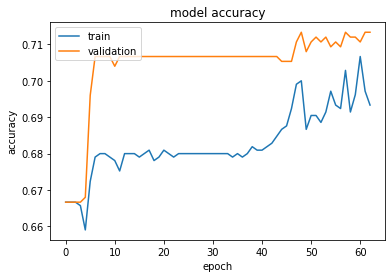

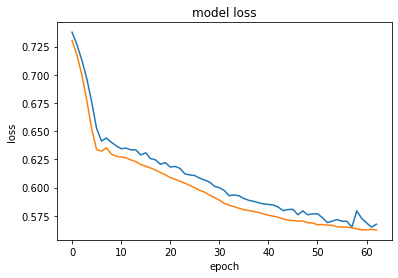

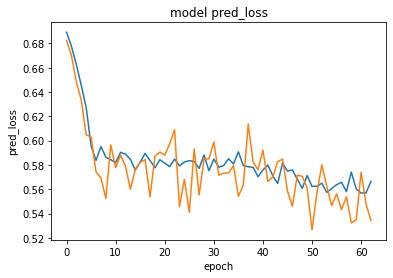

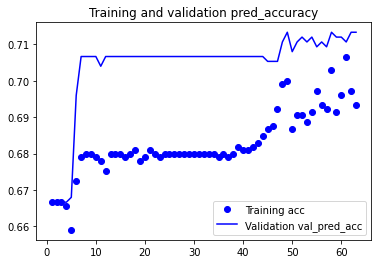

<Figure size 432x288 with 0 Axes>

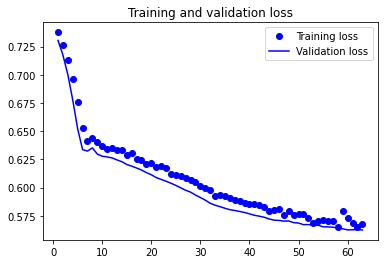

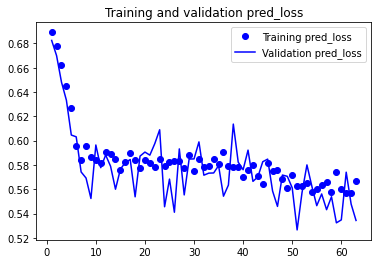

In [20]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()


pred_acc = history.history['pred_acc']
val_pred_acc = history.history['val_pred_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

pred_loss = history.history['pred_loss']
val_pred_loss = history.history['val_pred_loss']

epochs = range(1, len(pred_acc) + 1)

plt.plot(epochs, pred_acc, 'bo', label='Training acc')
plt.plot(epochs, val_pred_acc, 'b', label='Validation val_pred_acc')
plt.title('Training and validation pred_accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, pred_loss, 'bo', label='Training pred_loss')
plt.plot(epochs, val_pred_loss, 'b', label='Validation pred_loss')
plt.title('Training and validation pred_loss')
plt.legend()
plt.show()

**Teste_2**

In [ ]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=100, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


In [ ]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()


pred_acc = history.history['pred_acc']
val_pred_acc = history.history['val_pred_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

pred_loss = history.history['pred_loss']
val_pred_loss = history.history['val_pred_loss']

epochs = range(1, len(pred_acc) + 1)

plt.plot(epochs, pred_acc, 'bo', label='Training acc')
plt.plot(epochs, val_pred_acc, 'b', label='Validation val_pred_acc')
plt.title('Training and validation pred_accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, pred_loss, 'bo', label='Training pred_loss')
plt.plot(epochs, val_pred_loss, 'b', label='Validation pred_loss')
plt.title('Training and validation pred_loss')
plt.legend()
plt.show()

# Model7:** avec une couche mais utilisant Sgd optimazers**


In [23]:
MODEL_FILE_PATH = '/content/drive/MyDrive/dossier_de_travail/'
MODEL_FILE_NAME = 'model7_SGD.h5'
LR=0.001

batch_size = 128
vocab_size=vocab_size
max_length=100 
dim_latent=200
intermediate_dim=500

encoder = None
decoder = None
predicter_opinion = None
autoencoder = None

x = Input(shape=(max_length,))
x_embed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)(x)


def Encodeur(x, dim_latent=200, max_length=100, epsilon_std=0.01):
    h = Bidirectional(LSTM(500, return_sequences=True,dropout=0.2,recurrent_dropout=0.2),merge_mode='concat')(x)
    h = AttentionCouche()(h) 
    h = Dense(300, activation='relu', name='dense_1')(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim_latent), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    
    z_mean = Dense(dim_latent, name='z_mean', activation='linear')(h)
    z_log_var = Dense(dim_latent, name='z_log_var', activation='linear')(h)
    z = Lambda(sampling, output_shape=(dim_latent,), name='z')([z_mean, z_log_var])


    def fct_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    return (fct_loss, z)
    
     
fct_loss, encoded = Encodeur(x_embed, dim_latent=dim_latent, max_length=max_length)
encoder = Model(inputs=x, outputs=encoded)
encoder.summary()


def Codage_opinion(encoded):
    h = Dense(100, activation='linear')(encoded)     
    return Dense(3, activation='softmax', name='pred')(h)


encoded_input = Input(shape=(dim_latent,))
opinion_lab = Codage_opinion(encoded_input)
predicter_opinion = Model(encoded_input, opinion_lab)
predicter_opinion.summary()


def Decodeur(encoded, vocab_size, max_length):
    repeated_context = RepeatVector(max_length)(encoded)
    h = LSTM(500, return_sequences=True, name='dec_lstm_1')(repeated_context)
    decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)        
    return decoded


decoded = Decodeur(encoded_input, vocab_size, max_length)
decoder = Model(encoded_input, decoded)
decoder.summary()
autoencoder = Model(inputs=x, outputs=[Decodeur(encoded, vocab_size, max_length), Codage_opinion(encoded)])
tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


early_stopping = EarlyStopping(monitor='pred_loss', mode='min', verbose=1, patience=10)

save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                     monitor='pred_loss', mode='min',
                     save_best_only=True) 
autoencoder.compile(optimizer='sgd', loss=[fct_loss, 'binary_crossentropy'], metrics=['accuracy'])
autoencoder.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     2281400     input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 100, 1000)    2404000     embedding_3[0][0]                
__________________________________________________________________________________________________
attention_couche_3 (AttentionCo (None, 1000)         1100        bidirectional_9[0][0]            
____________________________________________________________________________________________

In [24]:

history = autoencoder.fit(x=X_train, y={'decoded_mean': Conversion_X_train, 'pred': y_train}, batch_size=80, epochs=80, validation_data=(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test}),callbacks=[early_stopping, save_best])


Train on 350 samples, validate on 250 samples
Epoch 1/80
350/350 [==============================] - ETA: 0s - loss: 0.7377 - decoded_mean_loss: 0.0484 - pred_loss: 0.6891 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


350/350 [==============================] - 80s 230ms/sample - loss: 0.7377 - decoded_mean_loss: 0.0484 - pred_loss: 0.6891 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667 - val_loss: 0.7331 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6846 - val_decoded_mean_acc: 0.0000e+00 - val_pred_acc: 0.6667
Epoch 2/80
350/350 [==============================] - 66s 190ms/sample - loss: 0.7319 - decoded_mean_loss: 0.0484 - pred_loss: 0.6831 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667 - val_loss: 0.7271 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6793 - val_decoded_mean_acc: 0.0037 - val_pred_acc: 0.6667
Epoch 3/80
350/350 [==============================] - 67s 190ms/sample - loss: 0.7258 - decoded_mean_loss: 0.0484 - pred_loss: 0.6775 - decoded_mean_acc: 0.0000e+00 - pred_acc: 0.6667 - val_loss: 0.7215 - val_decoded_mean_loss: 0.0484 - val_pred_loss: 0.6749 - val_decoded_mean_acc: 0.0000e+00 - val_pred_acc: 0.6667
Epoch 4/80
350/350 [==============================] - 67s 192ms/

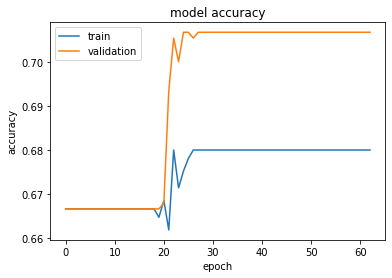

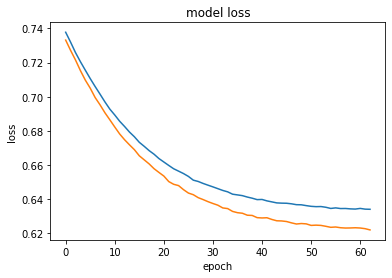

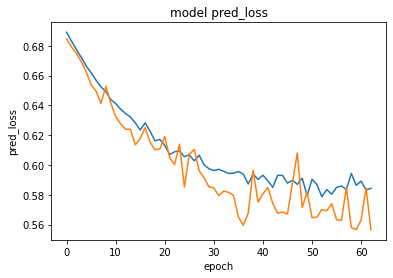

In [26]:
plt.plot(history.history['pred_acc'])
plt.plot(history.history['val_pred_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['pred_loss'])
plt.plot(history.history['val_pred_loss'])
plt.title('model pred_loss')
plt.ylabel('pred_loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
autoencoder.evaluate(X_test, {'decoded_mean': Conversion_X_test, 'pred':  y_test})